# Deep Learning model implementation

Oscar Eduardo Nieto Espitia - A01705090

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import glob, os

# Set a random seed for reproducibility
random.seed(42)

In [49]:
def plot_training_history(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(training_accuracy, label='Training Accuracy', color='blue', linestyle='-', marker='o')
    axes[0].plot(validation_accuracy, label='Validation Accuracy', color='green', linestyle='-', marker='o')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(training_loss, label='Training Loss', color='blue', linestyle='-', marker='o')
    axes[1].plot(validation_loss, label='Validation Loss', color='green', linestyle='-', marker='o')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()

    plt.show()

Here, I define the path to the dataset and use the glob module to create a list of image file paths in the dataset.

The Garbage Classification Dataset is a collection of images of various types of waste items, which have been categorized into six different classes. Each class represents a specific type of garbage, and the dataset provides images for each class.

- Cardboard: 393 images
- Glass: 491 images
- Metal: 400 images
- Paper: 584 images
- Plastic: 472 images
- Trash: 127 images

In [2]:
base_path = './data/garbage classification/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


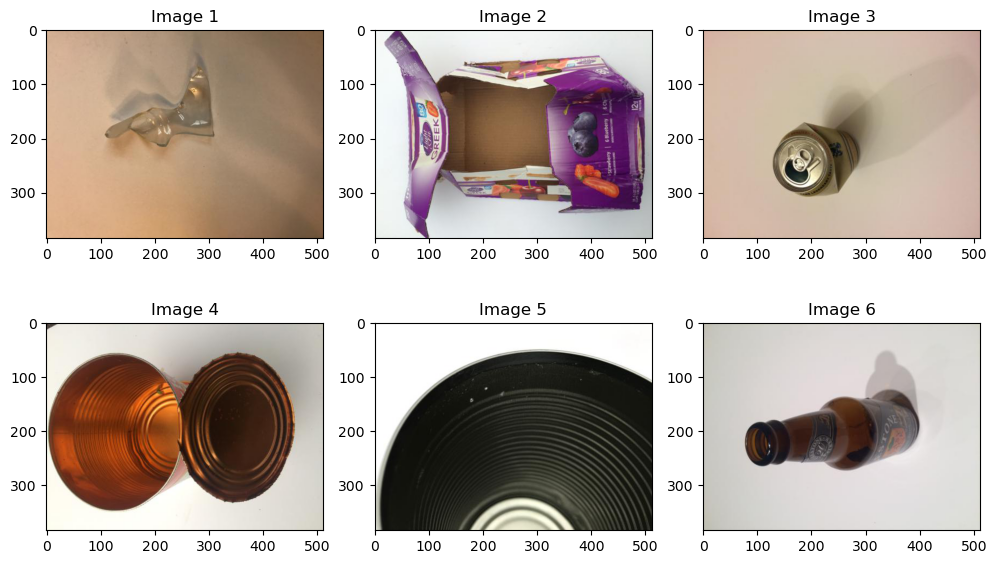

In [3]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img_path = random.choice(img_list)
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    ax.imshow(img.squeeze())
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

## Data Augmentation

Data augmentation is used to make the training dataset more diverse, helping the model learn to handle various real-world scenarios. It's essential for the model to generalize better and make accurate predictions on unseen data. 

We just want to augment the data of the training dataset becuase the validation and test datasets are used to evaluate the model's performance. They should represent real-world, unseen data. Applying data augmentation to these datasets would defeat the purpose of testing the model's ability to generalize to new, unaltered data.

In [39]:
# Parameters for Data augmentation for the training dataset
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
    brightness_range=[0.7, 1.3],
    rotation_range=15
)

# Parameters for Data augmentation for the rest of the datasets (test and validation)
test_datagenerator = ImageDataGenerator(
    rescale=1./255
)

In [40]:
# Apply data augmentation for the training data
train_generator = train_datagenerator.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagenerator.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
)

test_generator = test_datagenerator.flow_from_directory(
	base_path,
	target_size = (150, 150),
	batch_size = 20,
	class_mode= 'categorical')

# Map class indices to class labels
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

# Print the class labels
print("Class Labels:")
for label_index, label_name in labels.items():
    print(f"Class {label_index}: {label_name}")

Found 2276 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Class Labels:
Class 0: cardboard
Class 1: glass
Class 2: metal
Class 3: paper
Class 4: plastic
Class 5: trash


## Model 1

- Transfer Learning with VGG16: The use of the VGG16 pre-trained model with weights='imagenet' is an effective form of transfer learning. This allows your model to start with a strong foundation in understanding image features.

- Flatten Layer: The layers.Flatten() layer is used to flatten the output from the convolutional layers.

- Dense Layers: The first dense layer with 256 units serves as a feature extractor, learning high-level features from the flattened feature maps. The ReLU activation introduces non-linearity, which is crucial for capturing complex patterns in the data. The final dense layer with 6 units and a softmax activation is responsible for making predictions across the six classes.


- Model Compilation: The choice of categorical_crossentropy as the loss function is suitable for multi-class classification problems.

In [41]:
conv_base= VGG16(weights='imagenet',
							include_top = False,
							input_shape = (300,300,3))

model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(6,activation='softmax'))

conv_base.trainable = False

model1.summary()

model1.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=2e-5),
               metrics=['acc'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 41472)             0         
                                                                 
 dense_17 (Dense)            (None, 256)               10617088  
                                                                 
 dense_18 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 25333318 (96.64 MB)
Trainable params: 10618630 (40.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [43]:
history1 = model1.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 50,
				validation_data = validation_generator,
				validation_steps=25,
    			verbose=1)

Epoch 1/50
30/30 [==============================] - 84s 3s/step - loss: 1.3687 - accuracy: 0.4500 - val_loss: 1.2694 - val_accuracy: 0.4975
Epoch 2/50
30/30 [==============================] - 84s 3s/step - loss: 1.2408 - accuracy: 0.5375 - val_loss: 1.1315 - val_accuracy: 0.5700
Epoch 3/50
30/30 [==============================] - 84s 3s/step - loss: 1.2216 - accuracy: 0.5125 - val_loss: 1.0925 - val_accuracy: 0.6025
Epoch 4/50
30/30 [==============================] - 83s 3s/step - loss: 1.1618 - accuracy: 0.5542 - val_loss: 0.9970 - val_accuracy: 0.6350
Epoch 5/50
30/30 [==============================] - 86s 3s/step - loss: 1.0400 - accuracy: 0.5979 - val_loss: 1.0475 - val_accuracy: 0.5725
Epoch 6/50
30/30 [==============================] - 84s 3s/step - loss: 1.0184 - accuracy: 0.6042 - val_loss: 1.0040 - val_accuracy: 0.6050
Epoch 7/50
30/30 [==============================] - 85s 3s/step - loss: 1.0310 - accuracy: 0.6000 - val_loss: 0.9719 - val_accuracy: 0.6150
Epoch 8/50
30/30 [==

Both training and validation accuracies improve over time, indicating that the model is learning and generalizing from the data.

The training accuracy is consistently higher than the validation accuracy, and the training loss is consistently lower than the validation loss. This suggests that the model is overfitting to the training data.

An accuracy of around 80.25% on the validation set is a decent result, especially considering the model architecture and the amount of training data. However, there is still room for improvement.

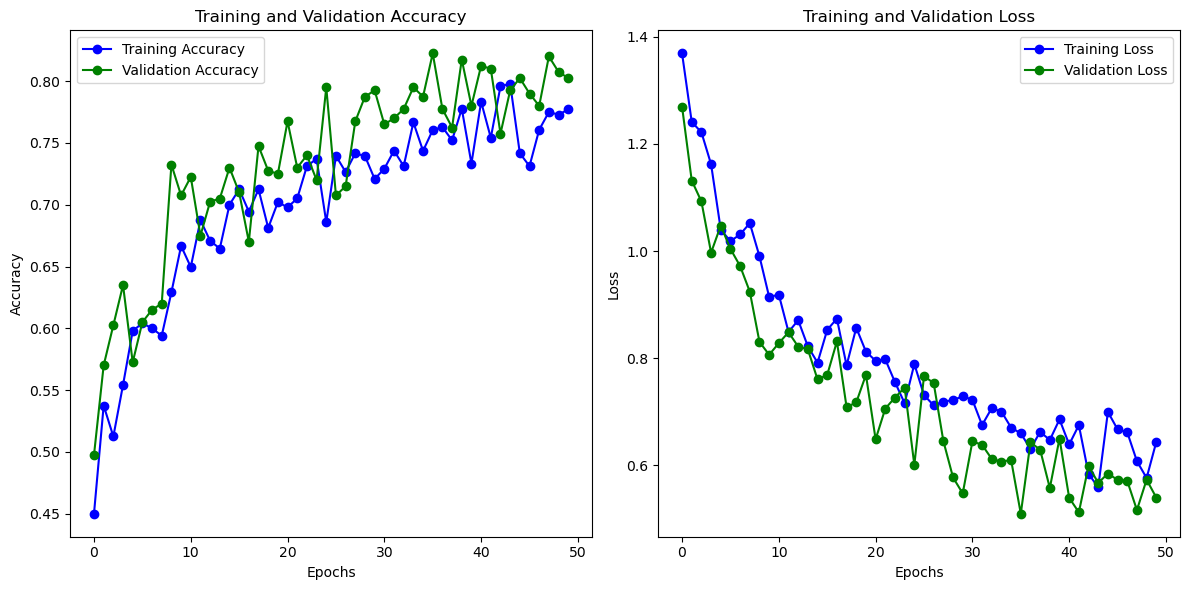

In [50]:
plot_training_history(history1)

In [51]:
model1.save('Trash1.h5')
model1.save('Trash1.keras')

c:\Users\oscar\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 2

- L2 regularization helps prevent overfitting by adding a penalty term to the loss function that discourages large weight values. This can lead to a more robust and generalizable model.

- The addition of a Dropout layer is another significant improvement. Dropout is a regularization technique that randomly deactivates a portion of neurons during training, which helps prevent the model from relying too heavily on specific neurons and reduces overfitting.

In [52]:
from tensorflow.keras import regularizers

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(300, 300, 3))

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax'))

conv_base.trainable = False

model2.summary()

model2.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=2e-5),
                      metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 41472)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               10617088  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 25333318 (96.64 MB)
Trainable params: 10618630 (40.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [53]:
history2 = model2.fit(train_generator,
				steps_per_epoch = 60,
				epochs = 50,
				validation_data = validation_generator,
				validation_steps = 60)

Epoch 1/50
60/60 [==============================] - 201s 3s/step - loss: 6.6186 - accuracy: 0.2948 - val_loss: 6.1610 - val_accuracy: 0.4031
Epoch 2/50
60/60 [==============================] - 200s 3s/step - loss: 5.9873 - accuracy: 0.4427 - val_loss: 5.6746 - val_accuracy: 0.4885
Epoch 3/50
60/60 [==============================] - 197s 3s/step - loss: 5.5753 - accuracy: 0.4781 - val_loss: 5.2655 - val_accuracy: 0.5531
Epoch 4/50
60/60 [==============================] - 199s 3s/step - loss: 5.2188 - accuracy: 0.4875 - val_loss: 4.9138 - val_accuracy: 0.5729
Epoch 5/50
60/60 [==============================] - 189s 3s/step - loss: 4.8901 - accuracy: 0.5422 - val_loss: 4.6167 - val_accuracy: 0.5969
Epoch 6/50
60/60 [==============================] - 191s 3s/step - loss: 4.6349 - accuracy: 0.5432 - val_loss: 4.3060 - val_accuracy: 0.6635
Epoch 7/50
60/60 [==============================] - 186s 3s/step - loss: 4.3700 - accuracy: 0.5749 - val_loss: 4.1038 - val_accuracy: 0.6292
Epoch 8/50
60

In [57]:
history2 = model2.fit(train_generator,
				steps_per_epoch = 60,
				epochs = 10,
				validation_data = validation_generator,
				validation_steps = 60)

Epoch 1/10
60/60 [==============================] - 207s 3s/step - loss: 1.6385 - accuracy: 0.7437 - val_loss: 1.4807 - val_accuracy: 0.8021
Epoch 2/10
60/60 [==============================] - 189s 3s/step - loss: 1.6293 - accuracy: 0.7532 - val_loss: 1.4700 - val_accuracy: 0.8104
Epoch 3/10
60/60 [==============================] - 190s 3s/step - loss: 1.6007 - accuracy: 0.7427 - val_loss: 1.4576 - val_accuracy: 0.8177
Epoch 4/10
60/60 [==============================] - 202s 3s/step - loss: 1.6512 - accuracy: 0.7448 - val_loss: 1.4008 - val_accuracy: 0.8406
Epoch 5/10
60/60 [==============================] - 195s 3s/step - loss: 1.6213 - accuracy: 0.7406 - val_loss: 1.4310 - val_accuracy: 0.8302
Epoch 6/10
60/60 [==============================] - 210s 4s/step - loss: 1.5705 - accuracy: 0.7583 - val_loss: 1.4417 - val_accuracy: 0.8021
Epoch 7/10
60/60 [==============================] - 198s 3s/step - loss: 1.5722 - accuracy: 0.7468 - val_loss: 1.4243 - val_accuracy: 0.8115
Epoch 8/10
60

The validation accuracy also increases over epochs. The validation accuracy is slightly higher than the training accuracy in this case, suggesting that the model generalizes well to unseen data.

Overfitting: The model does not exhibit significant overfitting. Both the training and validation losses are decreasing over epochs, which is a positive sign. Additionally, the increasing validation accuracy demonstrates that the model is not just memorizing the training data but is able to make accurate predictions on new, unseen data. The dropout layer and L2 regularization in your model have likely played a role in preventing overfitting.

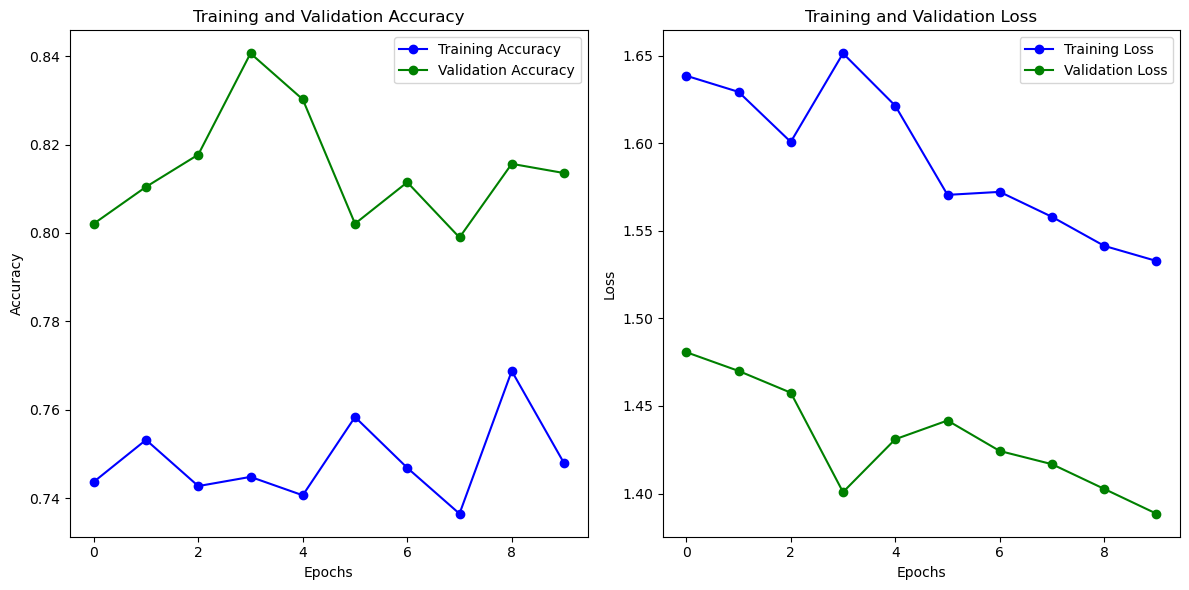

In [58]:
plot_training_history(history2)

In [59]:
model2.save('Trash2.h5')
model2.save('Trash2.keras')

1/1 [==============================] - 2s 2s/step


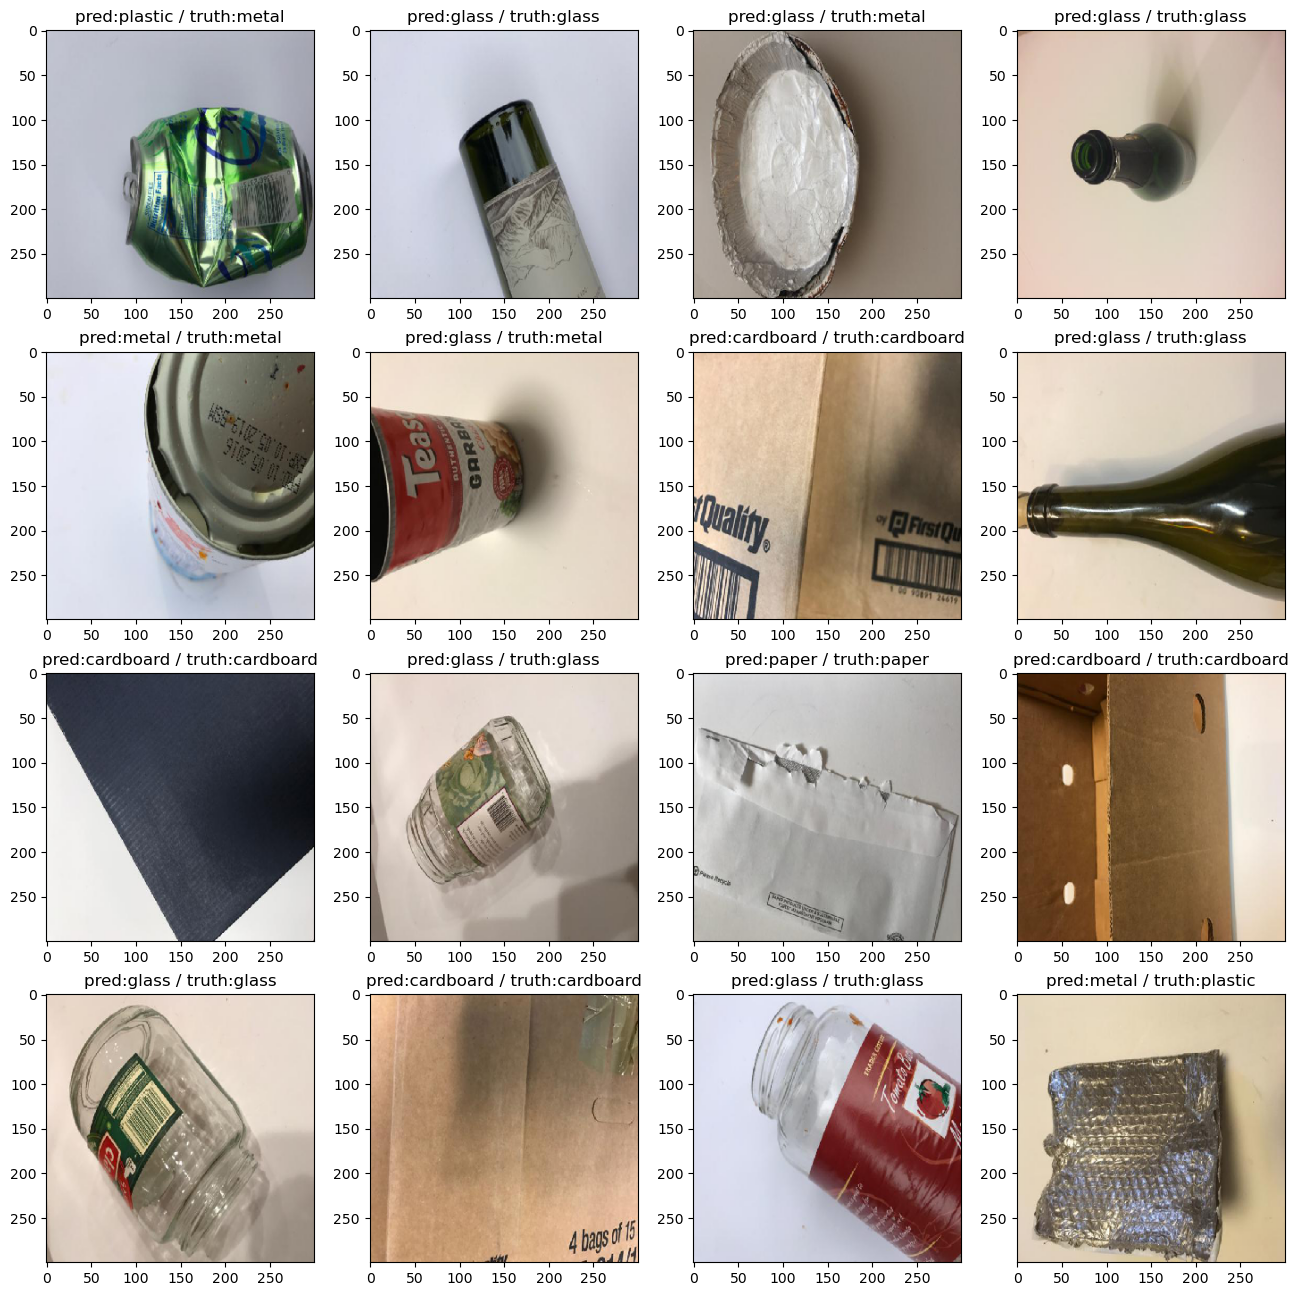

In [60]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model2.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])